## 3. Building CNN using Keras tensorflow

https://github.com/anujshah1003/own_data_cnn_implementation_keras

In [1]:
import pandas as pd
import numpy as np
# import os, cv2

from scipy import misc

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

/home/Jeryl/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from keras import backend as K
K.set_image_dim_ordering('tf')

import h5py

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
from keras.preprocessing import image

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


Load in pickle files and convert y (labels to one hot encoded matrix)

In [3]:
with open('keras_X_train', 'rb') as file:
    X_train = pickle.load(file)
    
with open('keras_y_train', 'rb') as file:
    y_train = pickle.load(file)
    
with open('keras_X_test', 'rb') as file:
    X_test = pickle.load(file)
    
with open('keras_y_test', 'rb') as file:
    y_test = pickle.load(file)

In [4]:
# convert class labels to on-hot encoding
Y_train = np_utils.to_categorical(y_train, num_classes=17)
del y_train

In [5]:
Y_test = np_utils.to_categorical(y_test, num_classes=17)
del y_test

In [6]:
num_classes = 17

## Defining model architecture
Image shape is 128 by 128 px, 3 channels.  
Model architecture = Convolution > relu > Convolution > relu > Max pool (with drop out) > Convolution > relu > convolution > relu > Max pool (drop out) > fully connected with activation > drop out > softmax activation.  

Model is optimised using Adam (adaptive moment estimation):

- Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models.
- Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.
- Adam is relatively easy to configure where the default configuration parameters do well on most problems.


In [7]:
# Defining the model
input_shape= (128,128,3)

model = Sequential()

model.add(Convolution2D(32, 3,border_mode='same',input_shape=input_shape, dim_ordering="tf"))
model.add(Activation('relu'))
# model.add(Convolution2D(32, 3, 3))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

model.add(Convolution2D(32, 3))
model.add(Activation('relu'))
#model.add(Convolution2D(64, 3, 3))
#model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Convolution2D(64, 3,border_mode='same',input_shape=input_shape, dim_ordering="tf"))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=["accuracy"])
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

/home/Jeryl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, 3, input_shape=(128, 128,..., padding="same", data_format="channels_last")`
  
/home/Jeryl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, 3, input_shape=(128, 128,..., padding="same", data_format="channels_last")`


In [8]:
# Viewing model_configuration

model.summary()
model.get_config()
model.layers[0].get_config()
model.layers[0].input_shape
model.layers[0].output_shape
model.layers[0].get_weights()
np.shape(model.layers[0].get_weights()[0])
model.layers[0].trainable

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 64)        18496     
__________

True

## callbacks
Use of callbacks allow you to monitor a metric and save weights of model when training is in progress

In [9]:
# Training with callbacks
from keras import callbacks

filename='model_train_new.csv'
csv_log=callbacks.CSVLogger(filename, separator=',', append=False)

# early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='min')

filepath="Best-weights-my_model-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [csv_log,checkpoint]

## Training
Training set is trained over 500 epochs, with a batch size of 128

In [12]:
# Training

num_epoch = 500
hist = model.fit(X_train, Y_train, batch_size=128,
                 epochs=num_epoch, 
                 validation_data=(X_test, Y_test),
                 callbacks=callbacks_list)

Train on 12835 samples, validate on 5502 samples
Epoch 1/500
12800/12835 [============================>.] - ETA: 0s - loss: 1.7270 - acc: 0.4321
Epoch 00001: val_loss improved from inf to 0.50602, saving model to Best-weights-my_model-001-1.7246-0.4328.hdf5
12835/12835 [==============================] - 56s 4ms/step - loss: 1.7246 - acc: 0.4328 - val_loss: 0.5060 - val_acc: 0.8442
Epoch 2/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.6501 - acc: 0.7795
Epoch 00002: val_loss improved from 0.50602 to 0.21648, saving model to Best-weights-my_model-002-0.6494-0.7797.hdf5
12835/12835 [==============================] - 45s 3ms/step - loss: 0.6494 - acc: 0.7797 - val_loss: 0.2165 - val_acc: 0.9338
Epoch 3/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.4238 - acc: 0.8534
Epoch 00003: val_loss improved from 0.21648 to 0.14501, saving model to Best-weights-my_model-003-0.4239-0.8534.hdf5
12835/12835 [==============================] - 45s 3ms/step - lo

Epoch 59/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0336 - acc: 0.9881
Epoch 00059: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0335 - acc: 0.9882 - val_loss: 0.0495 - val_acc: 0.9915
Epoch 60/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0315 - acc: 0.9892
Epoch 00060: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0314 - acc: 0.9892 - val_loss: 0.0440 - val_acc: 0.9905
Epoch 61/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0246 - acc: 0.9912
Epoch 00061: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0247 - acc: 0.9911 - val_loss: 0.0767 - val_acc: 0.9851
Epoch 62/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0303 - acc: 0.9897
Epoch 00062: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0303 - acc: 

Epoch 91/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0227 - acc: 0.9924
Epoch 00091: val_loss improved from 0.03956 to 0.03763, saving model to Best-weights-my_model-091-0.0227-0.9924.hdf5
12835/12835 [==============================] - 45s 4ms/step - loss: 0.0227 - acc: 0.9924 - val_loss: 0.0376 - val_acc: 0.9929
Epoch 92/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0298 - acc: 0.9904
Epoch 00092: val_loss improved from 0.03763 to 0.03543, saving model to Best-weights-my_model-092-0.0298-0.9903.hdf5
12835/12835 [==============================] - 45s 4ms/step - loss: 0.0298 - acc: 0.9903 - val_loss: 0.0354 - val_acc: 0.9933
Epoch 93/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9913
Epoch 00093: val_loss did not improve
12835/12835 [==============================] - 45s 4ms/step - loss: 0.0266 - acc: 0.9914 - val_loss: 0.0583 - val_acc: 0.9878
Epoch 94/500
12800/12835 [============================>.] -

Epoch 122/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0113 - acc: 0.9953
Epoch 00122: val_loss did not improve
12835/12835 [==============================] - 45s 4ms/step - loss: 0.0113 - acc: 0.9953 - val_loss: 0.0521 - val_acc: 0.9913
Epoch 123/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0195 - acc: 0.9934
Epoch 00123: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0195 - acc: 0.9934 - val_loss: 0.0606 - val_acc: 0.9898
Epoch 124/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0173 - acc: 0.9948
Epoch 00124: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0175 - acc: 0.9947 - val_loss: 0.0418 - val_acc: 0.9931
Epoch 125/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0143 - acc: 0.9949
Epoch 00125: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0143 - a

12800/12835 [============================>.] - ETA: 0s - loss: 0.0191 - acc: 0.9955
Epoch 00184: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0190 - acc: 0.9956 - val_loss: 0.1065 - val_acc: 0.9827
Epoch 185/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0119 - acc: 0.9965
Epoch 00185: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0119 - acc: 0.9965 - val_loss: 0.0387 - val_acc: 0.9935
Epoch 186/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0081 - acc: 0.9970
Epoch 00186: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0081 - acc: 0.9970 - val_loss: 0.0554 - val_acc: 0.9909
Epoch 187/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0108 - acc: 0.9967
Epoch 00187: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0108 - acc: 0.9967 - v

12800/12835 [============================>.] - ETA: 0s - loss: 0.0170 - acc: 0.9947
Epoch 00215: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0170 - acc: 0.9947 - val_loss: 0.0691 - val_acc: 0.9909
Epoch 216/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0124 - acc: 0.9962
Epoch 00216: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0123 - acc: 0.9962 - val_loss: 0.0469 - val_acc: 0.9920
Epoch 217/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0067 - acc: 0.9977
Epoch 00217: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0067 - acc: 0.9977 - val_loss: 0.0393 - val_acc: 0.9933
Epoch 218/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0054 - acc: 0.9985
Epoch 00218: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0054 - acc: 0.9985 - v

Epoch 246/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0082 - acc: 0.9972
Epoch 00246: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0081 - acc: 0.9972 - val_loss: 0.0476 - val_acc: 0.9924
Epoch 247/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0080 - acc: 0.9978
Epoch 00247: val_loss did not improve
12835/12835 [==============================] - 45s 4ms/step - loss: 0.0080 - acc: 0.9978 - val_loss: 0.0475 - val_acc: 0.9936
Epoch 248/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0057 - acc: 0.9978
Epoch 00248: val_loss did not improve
12835/12835 [==============================] - 45s 4ms/step - loss: 0.0057 - acc: 0.9978 - val_loss: 0.0541 - val_acc: 0.9925
Epoch 249/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0052 - acc: 0.9980
Epoch 00249: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0052 - a

Epoch 277/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.9973
Epoch 00277: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0099 - acc: 0.9973 - val_loss: 0.0436 - val_acc: 0.9927
Epoch 278/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0142 - acc: 0.9962
Epoch 00278: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0142 - acc: 0.9962 - val_loss: 0.0553 - val_acc: 0.9900
Epoch 279/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9975
Epoch 00279: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0078 - acc: 0.9975 - val_loss: 0.0692 - val_acc: 0.9898
Epoch 280/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0105 - acc: 0.9970
Epoch 00280: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0105 - a

12800/12835 [============================>.] - ETA: 0s - loss: 0.0139 - acc: 0.9962
Epoch 00339: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0139 - acc: 0.9962 - val_loss: 0.0589 - val_acc: 0.9924
Epoch 340/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9973
Epoch 00340: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0078 - acc: 0.9974 - val_loss: 0.0560 - val_acc: 0.9925
Epoch 341/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.9976
Epoch 00341: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0099 - acc: 0.9976 - val_loss: 0.0565 - val_acc: 0.9911
Epoch 342/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0107 - acc: 0.9971
Epoch 00342: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0106 - acc: 0.9971 - v

12800/12835 [============================>.] - ETA: 0s - loss: 0.0040 - acc: 0.9986
Epoch 00401: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0040 - acc: 0.9986 - val_loss: 0.0591 - val_acc: 0.9927
Epoch 402/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0087 - acc: 0.9977
Epoch 00402: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0086 - acc: 0.9977 - val_loss: 0.0433 - val_acc: 0.9935
Epoch 403/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0058 - acc: 0.9981
Epoch 00403: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0058 - acc: 0.9981 - val_loss: 0.0422 - val_acc: 0.9922
Epoch 404/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0039 - acc: 0.9989
Epoch 00404: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0039 - acc: 0.9989 - v

12800/12835 [============================>.] - ETA: 0s - loss: 0.0063 - acc: 0.9980
Epoch 00432: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0062 - acc: 0.9980 - val_loss: 0.0404 - val_acc: 0.9942
Epoch 433/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0055 - acc: 0.9980
Epoch 00433: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0055 - acc: 0.9980 - val_loss: 0.0460 - val_acc: 0.9925
Epoch 434/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.9967
Epoch 00434: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0099 - acc: 0.9967 - val_loss: 0.0760 - val_acc: 0.9909
Epoch 435/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0122 - acc: 0.9970
Epoch 00435: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0122 - acc: 0.9970 - v

12800/12835 [============================>.] - ETA: 0s - loss: 0.0082 - acc: 0.9979
Epoch 00494: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0082 - acc: 0.9979 - val_loss: 0.0661 - val_acc: 0.9911
Epoch 495/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0111 - acc: 0.9973
Epoch 00495: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0111 - acc: 0.9973 - val_loss: 0.0693 - val_acc: 0.9896
Epoch 496/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0081 - acc: 0.9978
Epoch 00496: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0081 - acc: 0.9978 - val_loss: 0.0628 - val_acc: 0.9920
Epoch 497/500
12800/12835 [============================>.] - ETA: 0s - loss: 0.0092 - acc: 0.9977
Epoch 00497: val_loss did not improve
12835/12835 [==============================] - 45s 3ms/step - loss: 0.0092 - acc: 0.9977 - v

## Loss and accuracy visualisation

The loss and accuracy of our model is visualised using pyplot.

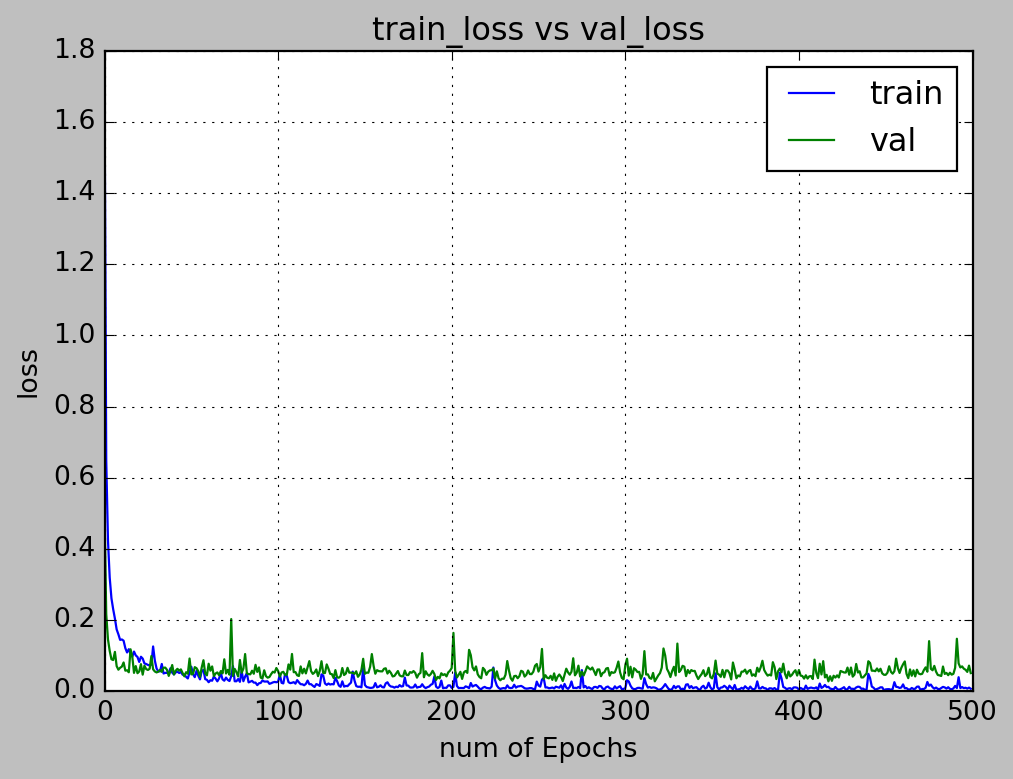

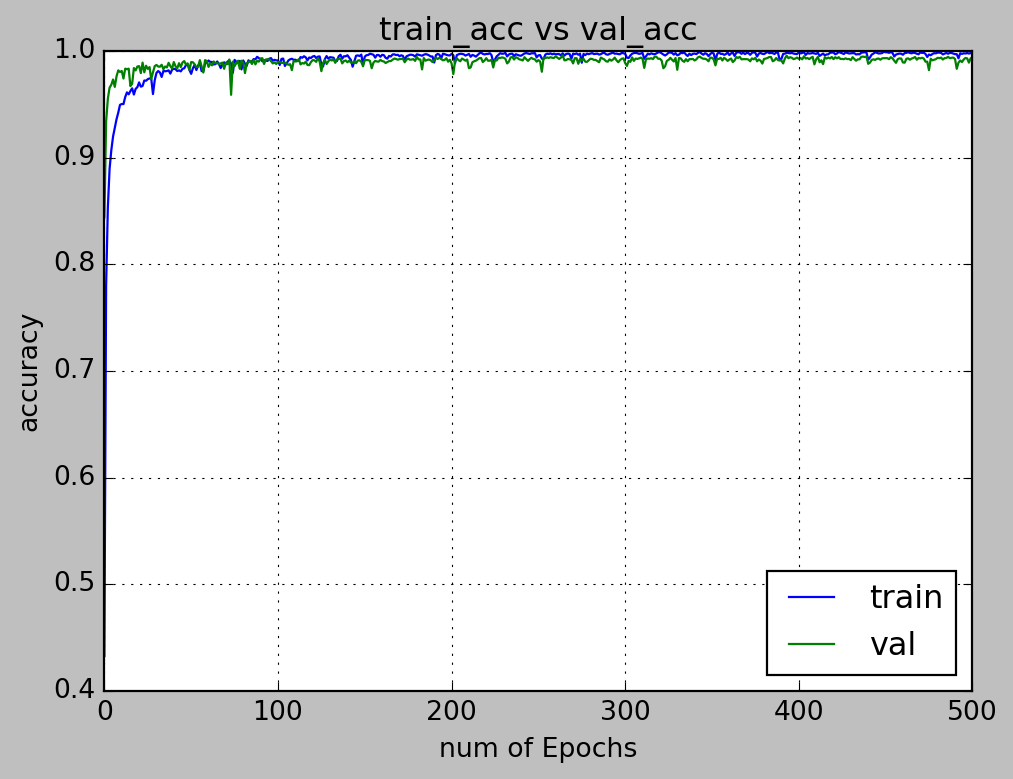

In [17]:
num_epoch = 500
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(num_epoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
plt.savefig('dropall1.jpeg')

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
plt.savefig('dropall2.jpeg')

## Model Evaluation
Our objective is to predict class of image from google images, thus load in the google images for evaluation and use our model to do prectiction of class.  

We chose epoch 192 weights as its the best balance between loss and accuracy (not too much overfitting).

In [3]:
# Loading model weights for best epoch , epoch = 192

from keras.models import load_model
loaded_model = load_model('./Weights drop all/Best-weights-my_model-192-0.0122-0.9962.hdf5')

In [4]:
# loading in google images for evaluation

with open('X_test', 'rb') as file:
    X_goog = pickle.load(file)
    
with open('y_test', 'rb') as file:
    y_goog = pickle.load(file)
    
Y_goog = np_utils.to_categorical(y_goog, num_classes=17)
del y_goog

In [5]:
# Evaluating the model

score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

NameError: name 'X_test' is not defined

In [6]:
# Evaluating the model

score = loaded_model.evaluate(X_goog, Y_goog, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 11.1707546597
Test accuracy: 0.27380952381


In [33]:
test_image = X_goog[55:56]
print (test_image.shape)

print(loaded_model.predict(test_image))
print(loaded_model.predict_classes(test_image))
print(Y_goog[55:56])

(1, 128, 128, 3)
[[  7.07963762e-25   1.22613013e-23   1.28087523e-11   2.65117538e-25
    1.28524820e-15   6.45168437e-20   3.22915257e-05   1.15314463e-22
    3.21261240e-10   4.87621282e-13   8.21023602e-25   9.99967694e-01
    2.59368519e-18   7.71639835e-24   1.19169067e-19   2.45650432e-18
    9.95940492e-15]]
[11]
[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [7]:
# Printing the confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = loaded_model.predict(X_test)
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)
#y_pred = model.predict_classes(X_test)
#print(y_pred)
target_names = ['class ' + str(x) for x in range(17)]

print(classification_report(np.argmax(Y_test,axis=1), y_pred,target_names=target_names))

print(confusion_matrix(np.argmax(Y_test,axis=1), y_pred))

NameError: name 'X_test' is not defined

In [8]:
# Printing the confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = loaded_model.predict(X_goog)
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)
#y_pred = model.predict_classes(X_test)
#print(y_pred)
target_names = ['class ' + str(x) for x in range(17)]

print(classification_report(np.argmax(Y_goog,axis=1), y_pred,target_names=target_names))

print(confusion_matrix(np.argmax(Y_goog,axis=1), y_pred))

[[  5.50455093e-20   1.54064732e-20   5.34174083e-09 ...,   4.82381376e-18
    9.43111041e-13   2.02346855e-11]
 [  1.52494886e-26   8.91189126e-28   1.00000000e+00 ...,   0.00000000e+00
    1.15320039e-28   2.30504217e-21]
 [  6.52397731e-25   1.78571223e-27   5.62543276e-11 ...,   4.12841724e-21
    2.63043993e-18   8.60820570e-09]
 ..., 
 [  0.00000000e+00   2.85461656e-31   6.62725711e-07 ...,   0.00000000e+00
    0.00000000e+00   4.25602387e-33]
 [  0.00000000e+00   0.00000000e+00   1.65890033e-34 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.42537870e-10 ...,   0.00000000e+00
    0.00000000e+00   5.32648744e-25]]
[ 6  2  6  6  9  9  4  9  9 11 11 11 11 11  6  6  6  6  6  6  6  6  6 15 15
 13 11  5  5  5  5  5  5  5 11  6  6  5  5  5  5  5  5  5  5 11  6 11  9  6
  6  9 11 11 11 11 11 11 11 11  6  4  6 11 11 12 15 11 13 11 13 11 11 11  9
 11  9  9  4  9  6  4  9  4]
             precision    recall  f1-score   support

    class

/home/Jeryl/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('conf_mat.jpg')

In [10]:
# Compute confusion matrix
cnf_matrix = (confusion_matrix(np.argmax(Y_goog,axis=1), y_pred))

np.set_printoptions(precision=2)

plt.figure()

Confusion matrix, without normalization
[[0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 4 0 0 0 0 0]
 [0 0 0 0 3 0 1 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 2 0 2 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0]
 [0 0 1 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 1 0]
 [0 0 0 0 0 0 2 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0]]


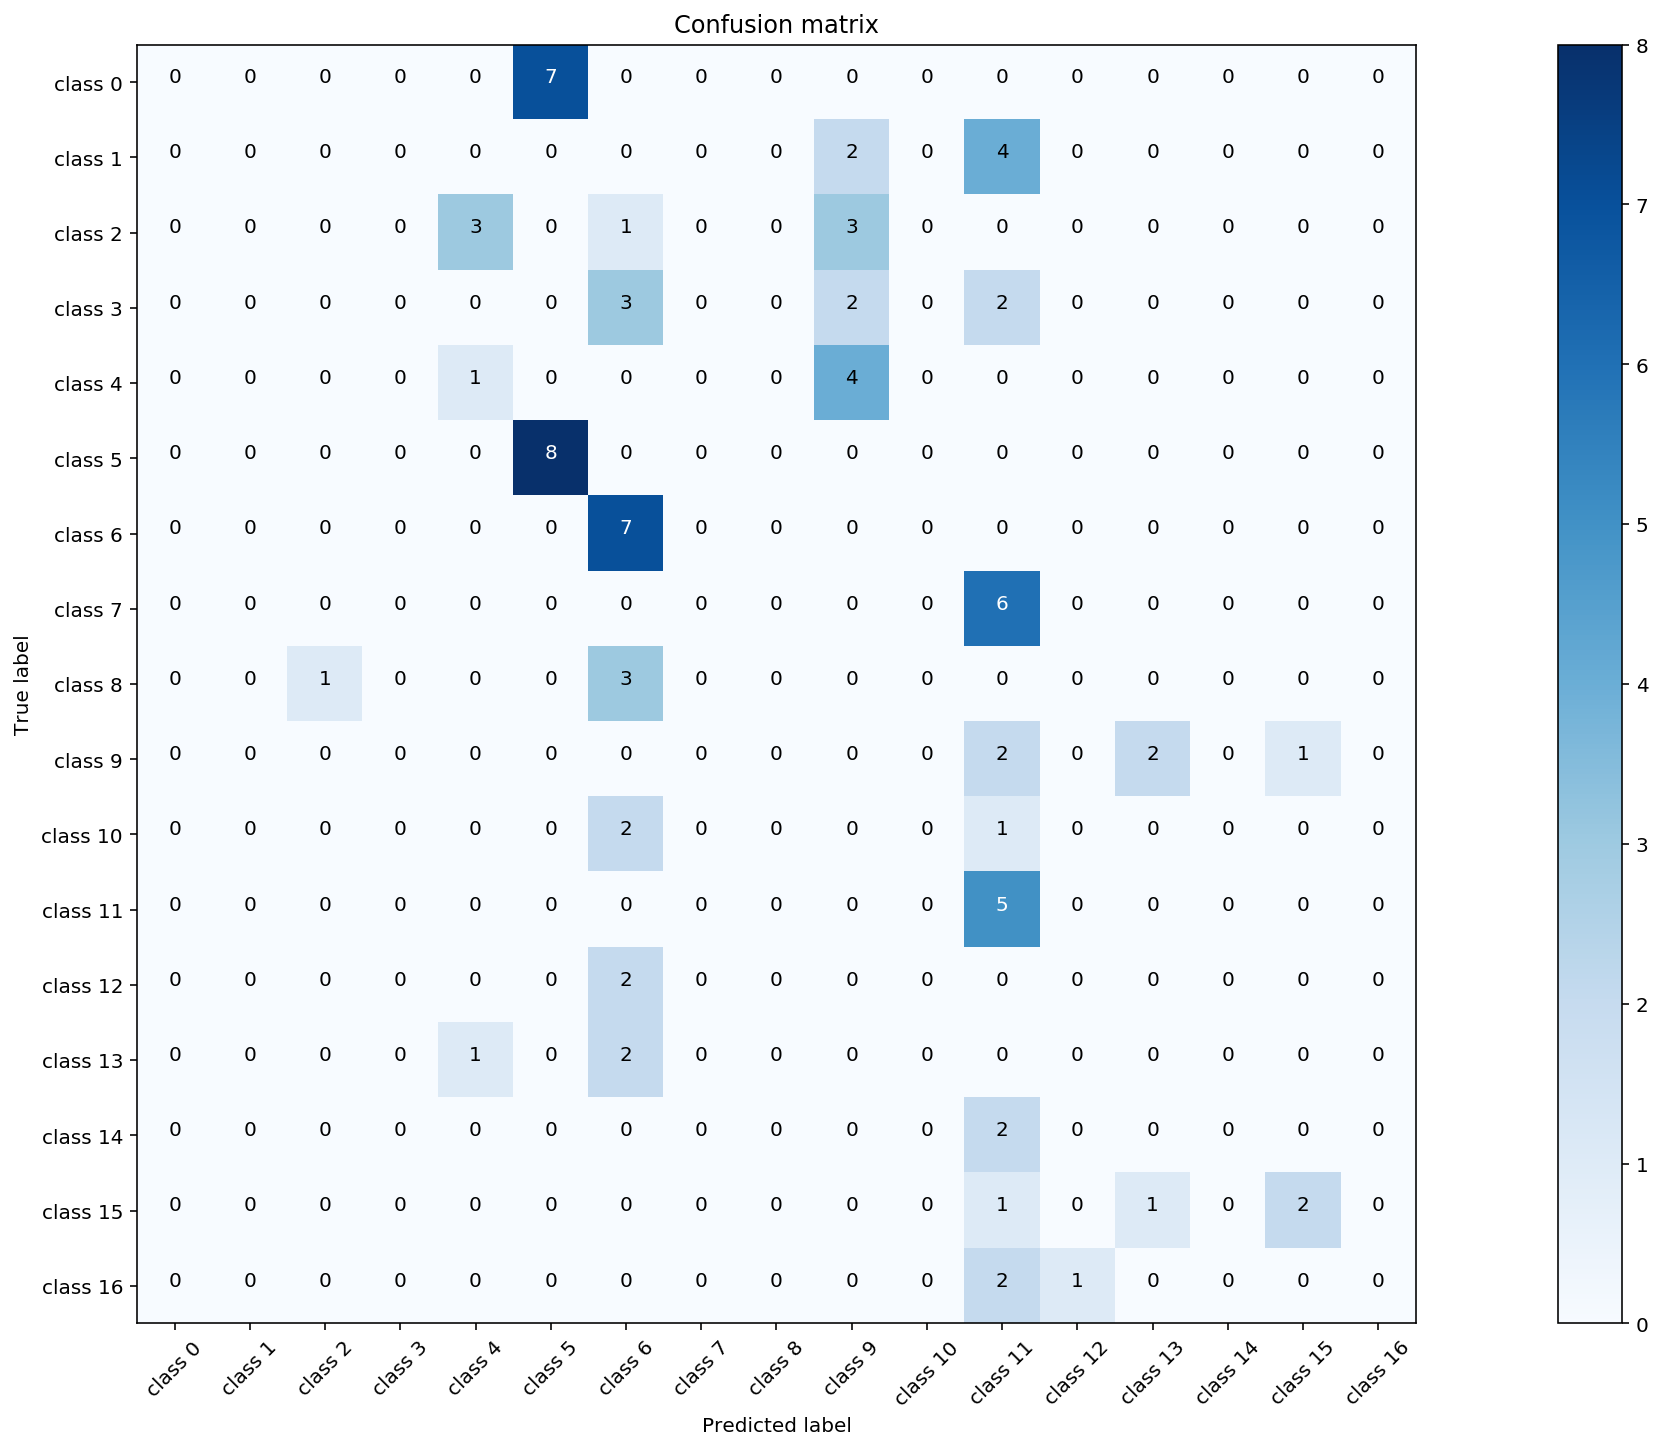

In [19]:
plt.figure(figsize=(20,10))
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')
plt.figure()

# Plot normalized confusion matrix
# plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
#                      title='Normalized confusion matrix')
# plt.figure()
# plt.show()

In [ ]:
# # Testing a new image
# test_image = cv2.imread('data/Humans/rider-8.jpg')
# test_image=cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
# test_image=cv2.resize(test_image,(128,128))
# test_image = np.array(test_image)
# test_image = test_image.astype('float32')
# test_image /= 255
# print (test_image.shape)
   
# if num_channel==1:
# 	if K.image_dim_ordering()=='th':
# 		test_image= np.expand_dims(test_image, axis=0)
# 		test_image= np.expand_dims(test_image, axis=0)
# 		print (test_image.shape)
# 	else:
# 		test_image= np.expand_dims(test_image, axis=3) 
# 		test_image= np.expand_dims(test_image, axis=0)
# 		print (test_image.shape)
		
# else:
# 	if K.image_dim_ordering()=='th':
# 		test_image=np.rollaxis(test_image,2,0)
# 		test_image= np.expand_dims(test_image, axis=0)
# 		print (test_image.shape)
# 	else:
# 		test_image= np.expand_dims(test_image, axis=0)
# 		print (test_image.shape)
		
# # Predicting the test image
# print((model.predict(test_image)))
# print(model.predict_classes(test_image))

# #%%

# # Visualizing the intermediate layer

# #
# def get_featuremaps(model, layer_idx, X_batch):
# 	get_activations = K.function([model.layers[0].input, K.learning_phase()],[model.layers[layer_idx].output,])
# 	activations = get_activations([X_batch,0])
# 	return activations

# layer_num=3
# filter_num=0

# activations = get_featuremaps(model, int(layer_num),test_image)

# print (np.shape(activations))
# feature_maps = activations[0][0]      
# print (np.shape(feature_maps))

# if K.image_dim_ordering()=='th':
# 	feature_maps=np.rollaxis((np.rollaxis(feature_maps,2,0)),2,0)
# print (feature_maps.shape)

# fig=plt.figure(figsize=(16,16))
# plt.imshow(feature_maps[:,:,filter_num],cmap='gray')
# plt.savefig("featuremaps-layer-{}".format(layer_num) + "-filternum-{}".format(filter_num)+'.jpg')

# num_of_featuremaps=feature_maps.shape[2]
# fig=plt.figure(figsize=(16,16))	
# plt.title("featuremaps-layer-{}".format(layer_num))
# subplot_num=int(np.ceil(np.sqrt(num_of_featuremaps)))
# for i in range(int(num_of_featuremaps)):
# 	ax = fig.add_subplot(subplot_num, subplot_num, i+1)
# 	#ax.imshow(output_image[0,:,:,i],interpolation='nearest' ) #to see the first filter
# 	ax.imshow(feature_maps[:,:,i],cmap='gray')
# 	plt.xticks([])
# 	plt.yticks([])
# 	plt.tight_layout()
# plt.show()
# fig.savefig("featuremaps-layer-{}".format(layer_num) + '.jpg')

# #%%